### 🔧 Installation de la bibliothèque RoboDK

Avant d'interagir avec le simulateur, nous devons installer la bibliothèque `robodk`, qui fournit une interface Python pour envoyer des commandes aux mécanismes de RoboDK (robots, convoyeurs, rails, etc.) et collecter les données nécessaires à notre projet de maintenance prédictive.


In [1]:
! pip install robodk

  Using cached robodk-5.9.0-py3-none-any.whl.metadata (13 kB)
Using cached robodk-5.9.0-py3-none-any.whl (120 kB)


# Instructions pour lancer la simulation et la collecte de données

1. **Ouvrez RoboDK** et chargez le fichier de projet `.rdk` correspondant à la simulation.

2. Dans RoboDK, **sélectionnez le programme nommé `MainStation`** qui contrôle la simulation .

3. Cliquez sur **« Run Program »** dans RoboDK pour lancer la simulation.

4. Une fois la simulation en cours d’exécution, **exécutez les cellules du notebook Python** pour collecter et visualiser les données en temps réel.

---

⚠️ **Remarque :** La collecte des données ne fonctionnera correctement que si la simulation est bien lancée et en fonctionnement dans RoboDK.


### 🧠 Exploration de la cellule RoboDK

Dans cette étape, nous nous connectons à la station RoboDK pour récupérer dynamiquement tous les éléments (robots, programmes, objets, repères, etc.). Cela nous permet de:

- Identifier les composants disponibles (robots, convoyeurs, rails, etc.)
- Vérifier les connexions hiérarchiques (parents/fils)
- Inspecter la configuration initiale des robots (valeurs d'articulations)
- Explorer les programmes RoboDK (séquences MoveJ, MoveL, etc.)

In [11]:
from robodk.robolink import Robolink, ITEM_TYPE_ROBOT, ITEM_TYPE_FRAME, ITEM_TYPE_OBJECT, ITEM_TYPE_TARGET, ITEM_TYPE_PROGRAM

RDK = Robolink()

# MODE = 'ALL' ou 'ROBOTS'
MODE = 'ALL'

if MODE == 'ALL':
    all_items = RDK.ItemList()
    for item in all_items:
        item_name = item.Name()
        item_type = item.Type()
        item_parent = item.Parent()
        parent_name = item_parent.Name() if item_parent.Valid() else 'Aucun'
        print(f"Nom : {item_name} | Type : {item_type} | Parent : {parent_name}")
        if item_type == ITEM_TYPE_ROBOT:
            print(f"  Joints : {item.Joints().tolist()}")
        if item_type == ITEM_TYPE_PROGRAM:
            instructions = item.InstructionList()
            print(f"  {len(instructions)} instructions")
            for instruction in instructions:
                print(f"    {instruction}")
        print("-" * 40)

elif MODE == 'ROBOTS':
    robots = RDK.ItemList(filter=ITEM_TYPE_ROBOT)
    for robot in robots:
        print("Robot :", robot.Name())


Nom : simulation | Type : 1 | Parent : Aucun
----------------------------------------
Nom : Palletizing | Type : 17 | Parent : simulation
----------------------------------------
Nom : Linear Rail Base | Type : 3 | Parent : Palletizing
----------------------------------------
Nom : Linear Rail | Type : 2 | Parent : Linear Rail Base
  Joints : [1200.0]
----------------------------------------
Nom : UR10e Base | Type : 3 | Parent : Linear Rail
----------------------------------------
Nom : UR10e_1 | Type : 2 | Parent : UR10e Base
  Joints : [89.3919209576803, -69.459782542502, -92.74418333538172, -197.7960341221124, -0.6080790423185362, 89.99999999999535]
----------------------------------------
Nom : Tool | Type : 4 | Parent : UR10e_1
----------------------------------------
Nom : Pick_Box | Type : 6 | Parent : UR10e Base
----------------------------------------
Nom : Transition_box | Type : 6 | Parent : UR10e Base
----------------------------------------
Nom : Ref_Target-0_0_0 | Type :

### 🤖 Identification des robots et mécanismes actifs

Après avoir connecté notre notebook à RoboDK, nous filtrons les éléments pour ne récupérer que les **robots industriels ou autres mécanismes mobiles** présents dans la station (bras, rails, convoyeurs modélisés comme robots, etc.).


In [2]:
from robodk.robolink import *  
# Établir la connexion avec RoboDK
RDK = Robolink()

# Récupérer tous les mécanismes ou robots
mechanisms = RDK.ItemList(filter=ITEM_TYPE_ROBOT)
for item in mechanisms:
    print("Mécanisme ou Robot :", item.Name())


Mécanisme ou Robot : Linear Rail
Mécanisme ou Robot : UR10e_1
Mécanisme ou Robot : UR10e_2
Mécanisme ou Robot : Conveyor_Bottle
Mécanisme ou Robot : Conveyor_Box
Mécanisme ou Robot : UR10e_3


# Script de collecte de données pour mécanismes RoboDK

Ce script permet de collecter des données en temps réel pour différents mécanismes dans une simulation RoboDK :  
- Robots (UR10e)  
- Convoyeurs  
- Rails linéaires  

Il collecte périodiquement les positions, vitesses et accélérations des joints ou des mécanismes, ainsi que la pose (position + orientation) des robots et des objets.  

Les données sont enregistrées dans des fichiers CSV, avec gestion du mode écriture/ajout, afin de pouvoir cumuler les données sur plusieurs cycles de collecte.

Le script fonctionne en boucle et propose à l'utilisateur de continuer ou d'arrêter la collecte après chaque cycle.

Une collecte parallèle est réalisée pour tous les mécanismes détectés dans la simulation afin d’optimiser le temps.

> ⚠️ **Remarque importante** :  
> Pour effectuer plusieurs cycles de collecte (reprises), il est **nécessaire de relancer manuellement la simulation** dans RoboDK entre chaque cycle.  
> En effet, RoboDK ne poursuit pas automatiquement la simulation une fois celle-ci arrêtée.


In [13]:
import csv
import time
import sys
from datetime import datetime
from robodk import robolink, robomath
from concurrent.futures import ThreadPoolExecutor

# Paramètres de la collecte
SAMPLE_INTERVAL = 0.1  # Intervalle entre mesures (secondes)
MAX_DURATION = 12     # Durée maximale de la collecte pour chaque mécanisme (secondes)

# Connexion à RoboDK
RDK = robolink.Robolink()

def collect_robot_data(robot, duration=MAX_DURATION, interval=SAMPLE_INTERVAL):
    """
    Collecte les données pour un robot UR10e.
    """
    data_log = []
    prev_joints = None
    prev_time = None
    prev_speeds = None
    start_time = time.time()

    while (time.time() - start_time) < duration:
        current_time = time.time()
        timestamp = datetime.now().isoformat()
        entry = {"timestamp": timestamp, "robot": robot.Name()}

        joints = robot.Joints().list()
        entry.update({f"joint_{i+1}_pos": joints[i] for i in range(len(joints))})

        if prev_joints is not None:
            dt = current_time - prev_time
            speeds = [(joints[i] - prev_joints[i]) / dt for i in range(len(joints))]
            entry.update({f"joint_{i+1}_speed": speeds[i] for i in range(len(speeds))})
            if prev_speeds is not None:
                accs = [(speeds[i] - prev_speeds[i]) / dt for i in range(len(speeds))]
                entry.update({f"joint_{i+1}_acc": accs[i] for i in range(len(accs))})
            else:
                entry.update({f"joint_{i+1}_acc": 0 for i in range(len(joints))})
            prev_speeds = speeds
        else:
            entry.update({f"joint_{i+1}_speed": 0 for i in range(len(joints))})
            entry.update({f"joint_{i+1}_acc": 0 for i in range(len(joints))})
            prev_speeds = [0] * len(joints)

        prev_joints = joints
        prev_time = current_time

        pose = robot.PoseTool()
        xyz = pose.Pos()
        rxyz = robomath.Pose_2_TxyzRxyz(pose)[3:]
        entry["tcp_x"] = xyz[0]
        entry["tcp_y"] = xyz[1]
        entry["tcp_z"] = xyz[2]
        entry["tcp_rx"] = rxyz[0]
        entry["tcp_ry"] = rxyz[1]
        entry["tcp_rz"] = rxyz[2]

        entry["cycle_time"] = current_time - start_time

        data_log.append(entry)
        time.sleep(interval)
    return data_log

def collect_conveyor_data(conveyor, duration=MAX_DURATION, interval=SAMPLE_INTERVAL):
    """
    Collecte les données pour un convoyeur.
    """
    data_log = []
    prev_pos = None
    prev_time = None
    start_time = time.time()

    while (time.time() - start_time) < duration:
        current_time = time.time()
        timestamp = datetime.now().isoformat()
        entry = {"timestamp": timestamp, "conveyor": conveyor.Name()}

        pose = conveyor.Pose()
        xyz = pose.Pos()
        entry["conveyor_pos_x"] = xyz[0]
        entry["conveyor_pos_y"] = xyz[1]
        entry["conveyor_pos_z"] = xyz[2]

        if prev_pos is not None:
            dt = current_time - prev_time
            speed_x = (xyz[0] - prev_pos[0]) / dt
            entry["conveyor_speed_x"] = speed_x
        else:
            entry["conveyor_speed_x"] = 0

        entry["cycle_time"] = current_time - start_time

        prev_pos = xyz
        prev_time = current_time

        data_log.append(entry)
        time.sleep(interval)
    return data_log

def collect_rail_data(rail, duration=MAX_DURATION, interval=SAMPLE_INTERVAL):
    """
    Collecte les données pour un rail linéaire.
    """
    data_log = []
    prev_val = None
    prev_time = None
    prev_speed = None
    start_time = time.time()

    while (time.time() - start_time) < duration:
        current_time = time.time()
        timestamp = datetime.now().isoformat()
        entry = {"timestamp": timestamp, "rail": rail.Name()}

        joints = rail.Joints().list()
        rail_pos = joints[0]
        entry["rail_position"] = rail_pos

        if prev_val is not None:
            dt = current_time - prev_time
            rail_speed = (rail_pos - prev_val) / dt
            entry["rail_speed"] = rail_speed
            if prev_speed is not None:
                rail_acc = (rail_speed - prev_speed) / dt
                entry["rail_acceleration"] = rail_acc
            else:
                entry["rail_acceleration"] = 0
            prev_speed = rail_speed
        else:
            entry["rail_speed"] = 0
            entry["rail_acceleration"] = 0
            prev_speed = 0

        prev_val = rail_pos
        prev_time = current_time

        entry["cycle_time"] = current_time - start_time
        data_log.append(entry)
        time.sleep(interval)
    return data_log

def collect_box_positions():
    """
    Collecte la pose de toutes les boxes dans la simulation.
    """
    all_items = RDK.ItemList()
    boxes = [item for item in all_items if "Box" in item.Name()]
    data_log = []
    timestamp = datetime.now().isoformat()
    for box in boxes:
        pose = box.Pose()
        xyz = pose.Pos()
        rxyz = robomath.Pose_2_TxyzRxyz(pose)[3:]
        entry = {
            "timestamp": timestamp,
            "box_name": box.Name(),
            "box_x": xyz[0],
            "box_y": xyz[1],
            "box_z": xyz[2],
            "box_rx": rxyz[0],
            "box_ry": rxyz[1],
            "box_rz": rxyz[2]
        }
        data_log.append(entry)
    return data_log

def save_to_csv(data, filename, mode="w"):
    """
    Sauvegarde les données dans un fichier CSV.
    Le mode peut être "w" (écraser) ou "a" (ajouter).
    """
    if not data:
        print(f"[AVERTISSEMENT] Aucune donnée à sauvegarder dans {filename}")
        return
    
    # Définir le mode d'écriture du fichier
    write_header = True
    if mode == "a":
        try:
            # Vérifier si le fichier existe déjà
            with open(filename, "r") as f:
                write_header = False
        except FileNotFoundError:
            # Si le fichier n'existe pas, on écrit l'en-tête
            write_header = True
    
    fieldnames = list(data[0].keys())
    with open(filename, mode, newline="") as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        if write_header:
            writer.writeheader()
        writer.writerows(data)
    print(f"[INFO] Données sauvegardées dans {filename} (mode: {mode})")

def collect_and_save(mech, file_mode="w"):
    """
    Collecte et sauvegarde les données pour un mécanisme spécifique.
    """
    name = mech.Name()
    data = []
    filename = ""

    if "Linear Rail" in name:
        print(f"[INFO] Collecting data for rail: {name}")
        data = collect_rail_data(mech)
        filename = f"{name.replace(' ', '_')}_rail_data.csv"
    elif "UR10e" in name:
        print(f"[INFO] Collecting data for robot UR10e: {name}")
        data = collect_robot_data(mech)
        filename = f"{name.replace(' ', '_')}_robot_data.csv"
    elif "Conveyor_Bottle" in name or "Conveyor_Box" in name:
        print(f"[INFO] Collecting data for conveyor: {name}")
        data = collect_conveyor_data(mech)
        filename = f"{name.replace(' ', '_')}_conveyor_data.csv"
    else:
        print(f"[INFO] Mechanism {name} ignored for targeted collection.")
        return

    if data:
        save_to_csv(data, filename, file_mode)

def prompt_for_continuation():
    """
    Demande à l'utilisateur s'il souhaite continuer la collecte ou quitter.
    Retourne True pour continuer, False pour quitter.
    """
    while True:
        choice = input("\n[PROMPT] Collecte terminée. Entrer 'r' pour reprendre ou 'q' pour quitter: ").lower()
        if choice == 'r':
            return True
        elif choice == 'q':
            return False
        else:
            print("[ERREUR] Option non valide. Veuillez entrer 'r' ou 'q'.")

def main():
    # Initialisation
    print("[INFO] Démarrage du programme de collecte de données RoboDK")
    print(f"[CONFIG] Intervalle d'échantillonnage: {SAMPLE_INTERVAL} sec")
    print(f"[CONFIG] Durée maximale par cycle: {MAX_DURATION} sec")
    
    # Boucle principale du programme
    cycle_count = 0
    continue_collection = True
    
    while continue_collection:
        cycle_count += 1
        print(f"\n[INFO] Début du cycle de collecte #{cycle_count}")
        
        # Détermine le mode d'écriture des fichiers (premier cycle = écraser, cycles suivants = ajouter)
        file_mode = "w" if cycle_count == 1 else "a"
        
        # Récupère tous les mécanismes
        all_items = RDK.ItemList()
        mechanisms = [item for item in all_items if any(keyword in item.Name() for keyword in ["UR10e", "Conveyor", "Linear Rail"])]
        
        # Collecte concurrente des données pour chaque mécanisme
        with ThreadPoolExecutor() as executor:
            # Crée une liste de tâches avec le mode d'écriture approprié
            tasks = [(mech, file_mode) for mech in mechanisms]
            executor.map(lambda args: collect_and_save(*args), tasks)
       
        
        # Demande à l'utilisateur s'il souhaite continuer ou quitter
        print("\n[INFO] Cycle de collecte terminé.")
        continue_collection = prompt_for_continuation()
    
    print("[INFO] Programme terminé.")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\n[INFO] Programme interrompu par l'utilisateur.")
        sys.exit(0) 

[INFO] Démarrage du programme de collecte de données RoboDK
[CONFIG] Intervalle d'échantillonnage: 0.1 sec
[CONFIG] Durée maximale par cycle: 12 sec

[INFO] Début du cycle de collecte #1
[INFO] Collecting data for rail: Linear Rail Base
Invalid item provided: The item identifier provided is not valid or it does not exist.
[INFO] Collecting data for rail: Linear Rail
[INFO] Collecting data for robot UR10e: UR10e Base
[INFO] Collecting data for robot UR10e: UR10e_2
[INFO] Collecting data for robot UR10e: UR10e Base
[INFO] Collecting data for robot UR10e: UR10e_1
[INFO] Mechanism Conveyor Belt Base Bottle ignored for targeted collection.
[INFO] Mechanism App_Box_Conveyor ignored for targeted collection.
Invalid item provided: The item identifier provided is not valid or it does not exist.
[INFO] Mechanism Place_Box_Conveyor ignored for targeted collection.
[INFO] Mechanism Wait_Conveyor_In_Ready ignored for targeted collection.
[INFO] Mechanism Conveyor Belt Base Box ignored for targeted 


[PROMPT] Collecte terminée. Entrer 'r' pour reprendre ou 'q' pour quitter:  r



[INFO] Début du cycle de collecte #2
[INFO] Collecting data for rail: Linear Rail Base
[INFO] Collecting data for rail: Linear Rail
[INFO] Collecting data for robot UR10e: UR10e Base
Invalid item provided: The item identifier provided is not valid or it does not exist.
[INFO] Collecting data for robot UR10e: UR10e Base
Invalid item provided: The item identifier provided is not valid or it does not exist.
[INFO] Collecting data for robot UR10e: UR10e_1
[INFO] Collecting data for conveyor: Conveyor_Bottle
[INFO] Mechanism Conveyor Bottle ignored for targeted collection.
[INFO] Mechanism Conveyor_3m ignored for targeted collection.
Invalid item provided: The item identifier provided is not valid or it does not exist.
[INFO] Collecting data for robot UR10e: UR10e_2
[INFO] Collecting data for conveyor: Conveyor_Box
[INFO] Mechanism Conveyor Box ignored for targeted collection.
[INFO] Mechanism Conveyor Belt Base Bottle ignored for targeted collection.
[INFO] Mechanism Conveyor_4m ignored f


[PROMPT] Collecte terminée. Entrer 'r' pour reprendre ou 'q' pour quitter:  r



[INFO] Début du cycle de collecte #3
[INFO] Collecting data for rail: Linear Rail Base
[INFO] Collecting data for rail: Linear Rail
Invalid item provided: The item identifier provided is not valid or it does not exist.
[INFO] Collecting data for robot UR10e: UR10e_1
[INFO] Collecting data for robot UR10e: UR10e_2
[INFO] Collecting data for robot UR10e: UR10e Base
[INFO] Mechanism Conveyor Belt Base Bottle ignored for targeted collection.
[INFO] Collecting data for conveyor: Conveyor_Bottle
[INFO] Mechanism Conveyor_3m ignored for targeted collection.
[INFO] Collecting data for robot UR10e: UR10e Base
[INFO] Mechanism Conveyor Belt Base Box ignored for targeted collection.
[INFO] Collecting data for conveyor: Conveyor_Box
[INFO] Mechanism Conveyor_4m ignored for targeted collection.
Invalid item provided: The item identifier provided is not valid or it does not exist.
[INFO] Collecting data for robot UR10e: UR10e_3
[INFO] Mechanism Place_Box_Conveyor ignored for targeted collection.
[I


[PROMPT] Collecte terminée. Entrer 'r' pour reprendre ou 'q' pour quitter:  q


[INFO] Programme terminé.


# Visualisation des données 

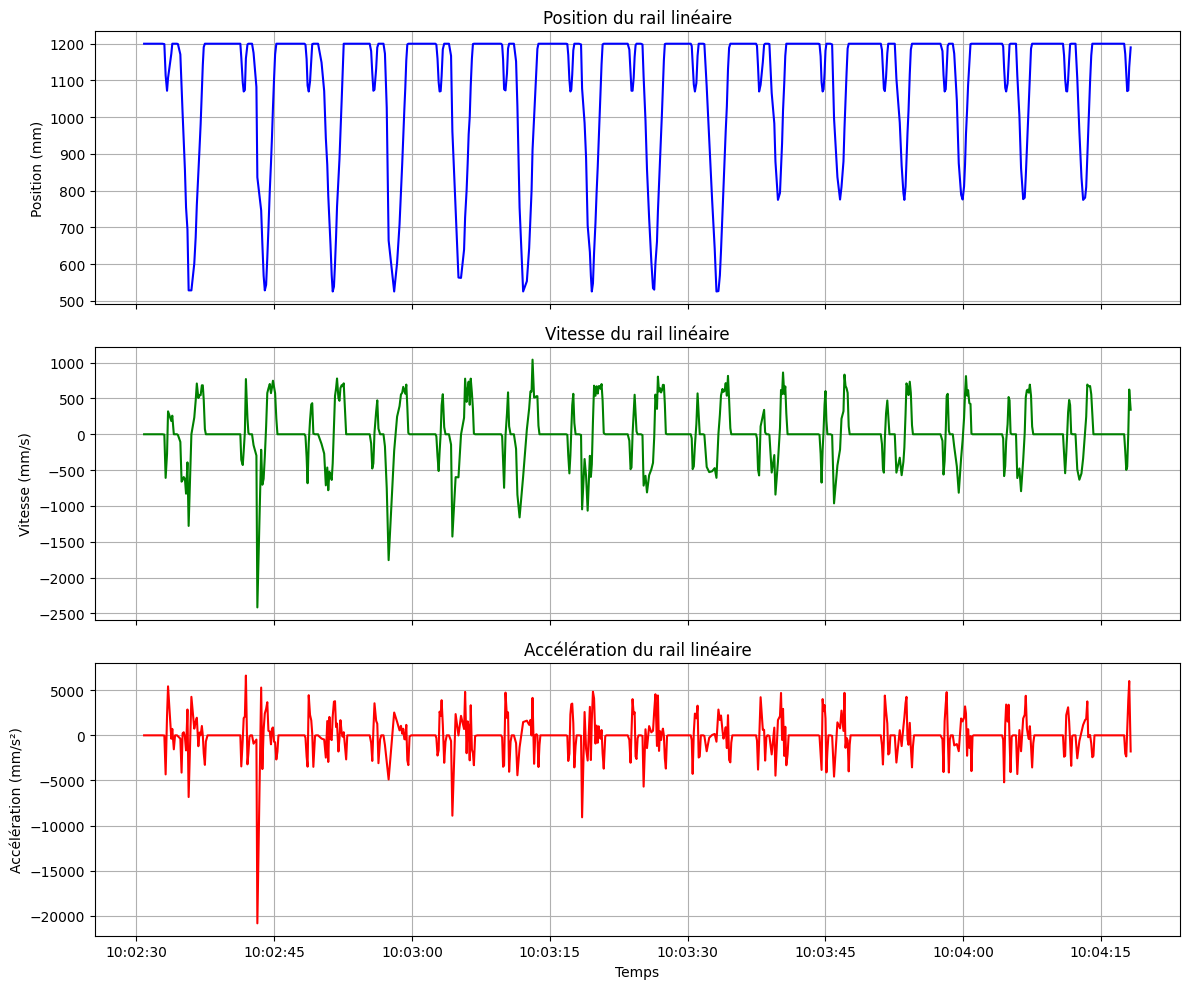

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_rail(filepath):
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

    axs[0].plot(df['timestamp'], df['rail_position'], color='blue')
    axs[0].set_ylabel("Position (mm)")
    axs[0].set_title("Position du rail linéaire")
    axs[0].grid(True)

    axs[1].plot(df['timestamp'], df['rail_speed'], color='green')
    axs[1].set_ylabel("Vitesse (mm/s)")
    axs[1].set_title("Vitesse du rail linéaire")
    axs[1].grid(True)

    axs[2].plot(df['timestamp'], df['rail_acceleration'], color='red')
    axs[2].set_ylabel("Accélération (mm/s²)")
    axs[2].set_xlabel("Temps")
    axs[2].set_title("Accélération du rail linéaire")
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()
rail_file = "Linear_Rail_rail_data.csv"
plot_rail(rail_file)


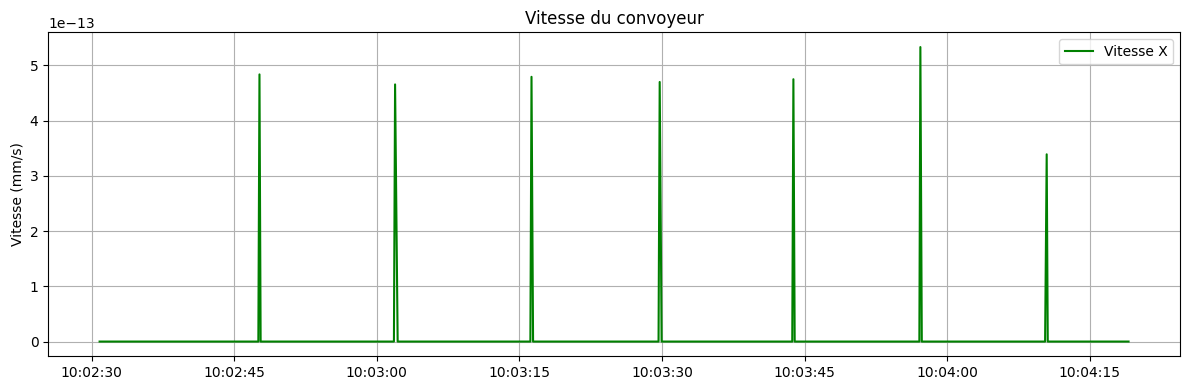

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Plot CONVOYEUR ===
def plot_conveyor(filepath):
    df = pd.read_csv(filepath)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    fig, ax = plt.subplots(1, 1, figsize=(12, 4), sharex=True)

    ax.plot(df['timestamp'], df['conveyor_speed_x'], color='green', label='Vitesse X')
    ax.set_ylabel("Vitesse (mm/s)")
    ax.set_title("Vitesse du convoyeur")
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    plt.show()

conveyor_file = "Conveyor_Box_conveyor_data.csv"
plot_conveyor(conveyor_file)

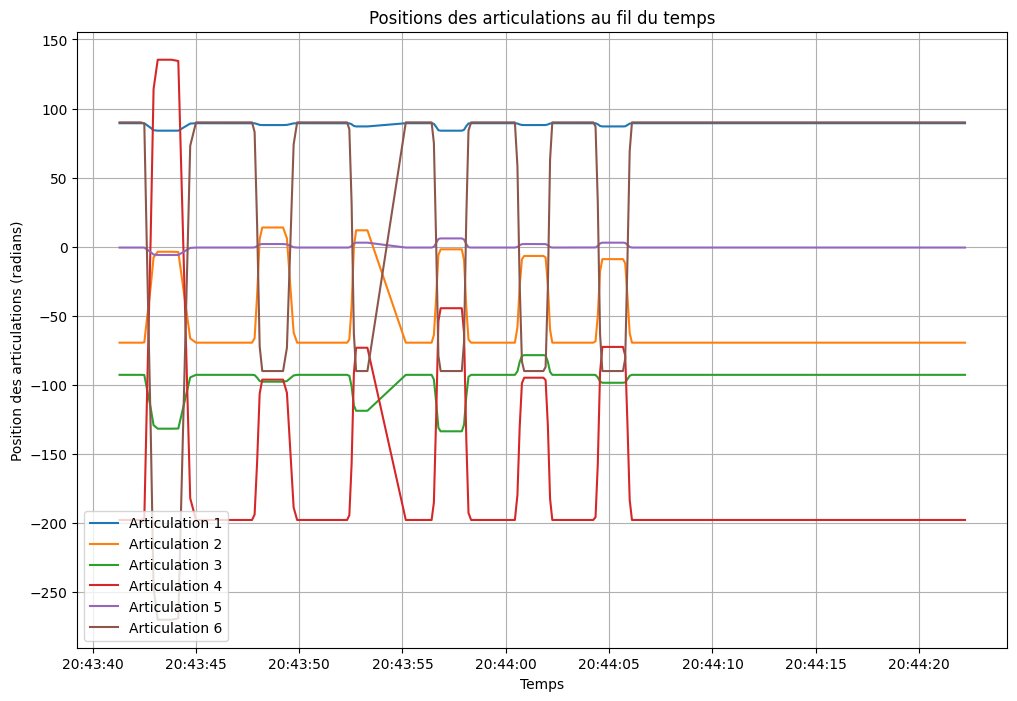

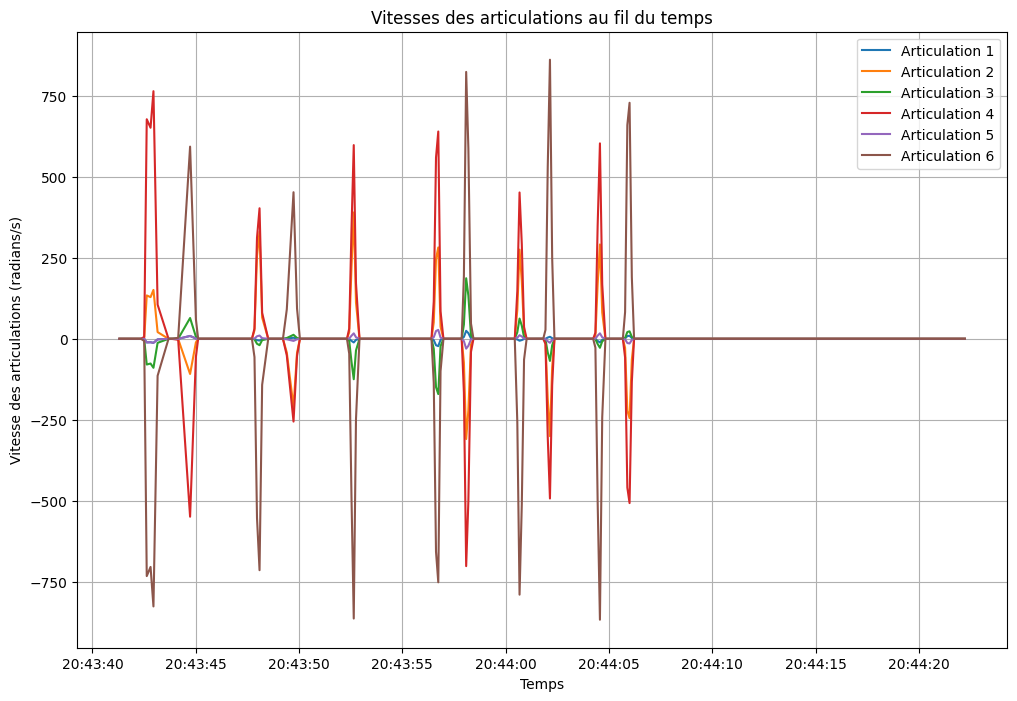

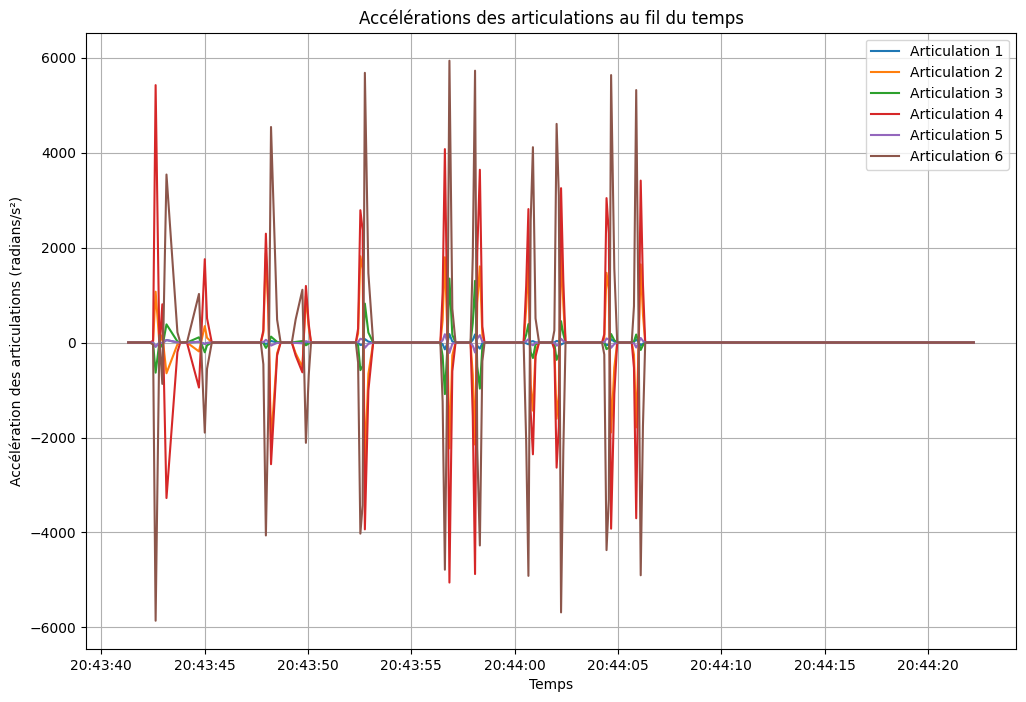

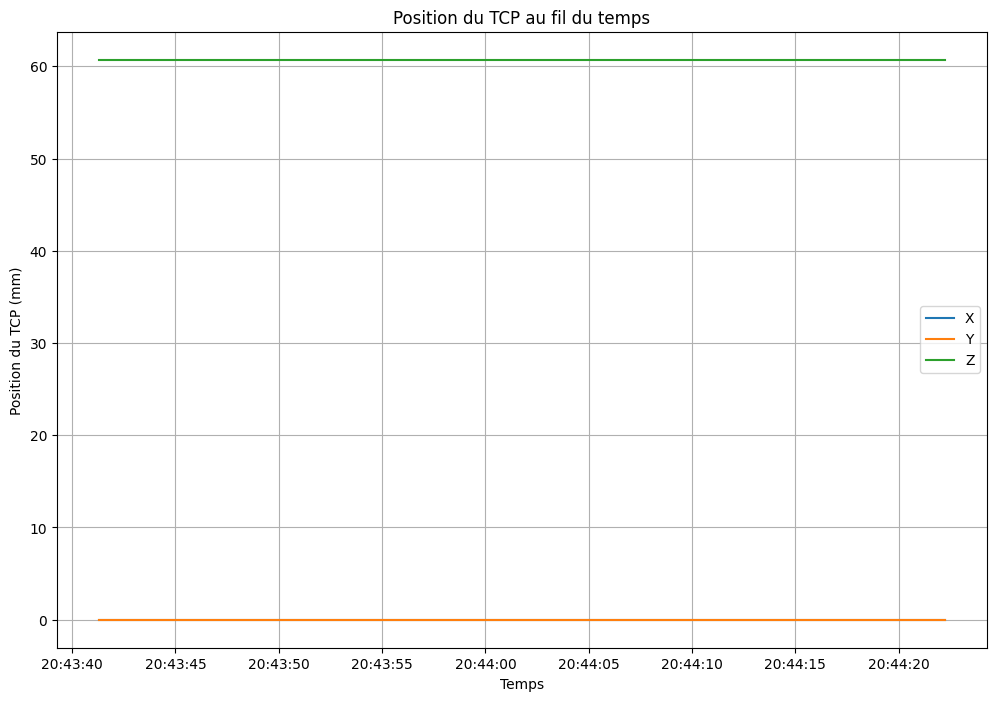

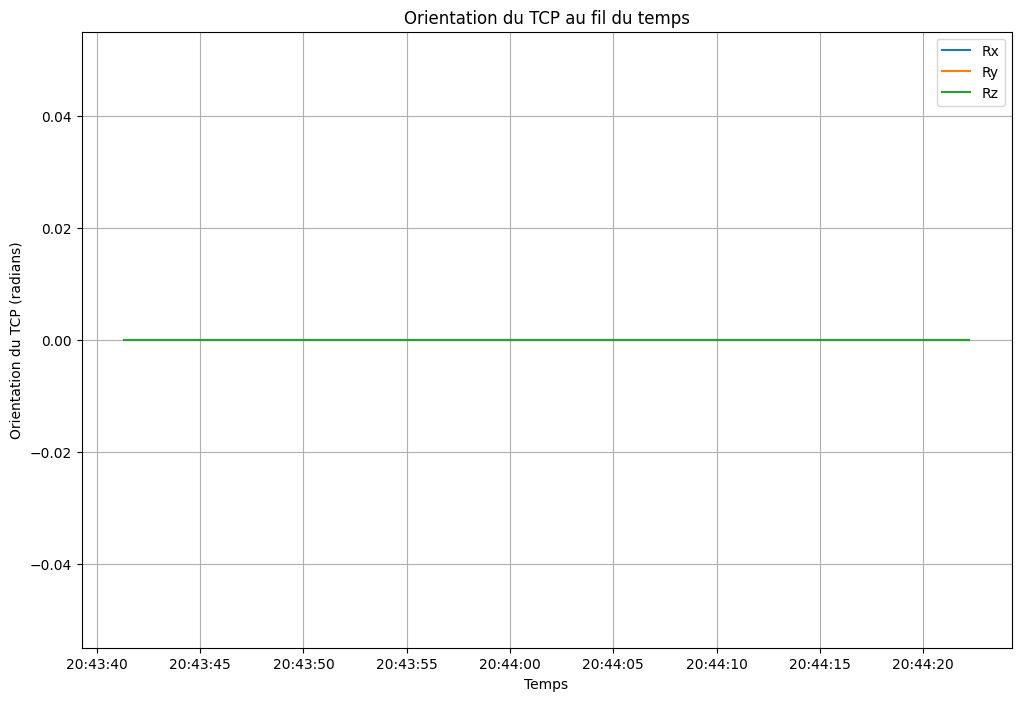

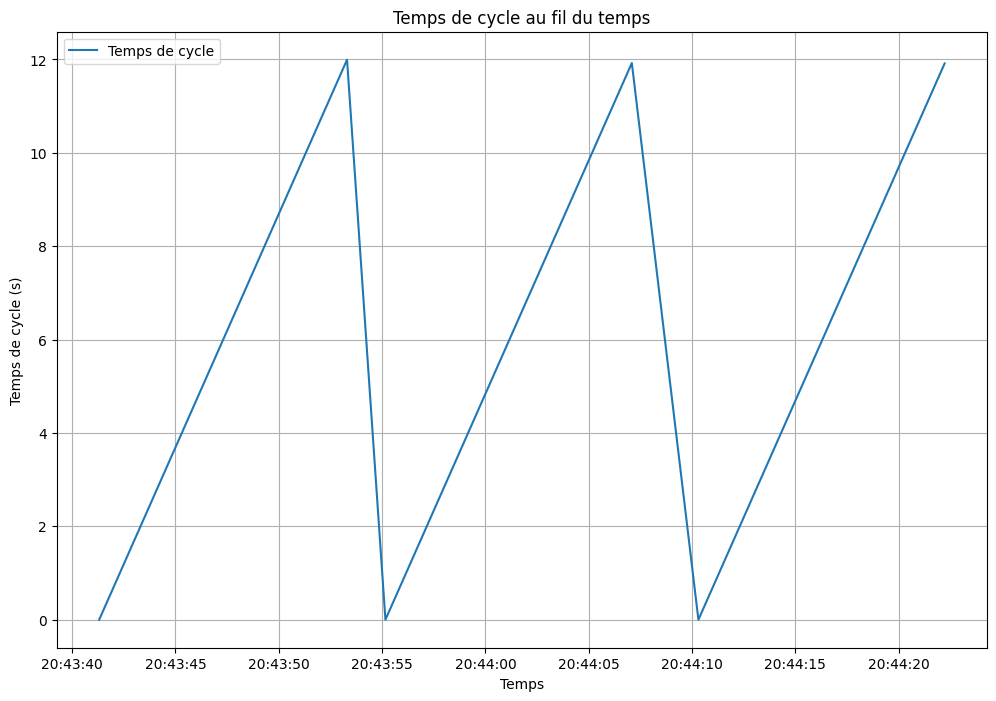

In [18]:
# Charger les données depuis le fichier CSV
filename = "UR10e_1_robot_data.csv"
data = pd.read_csv(filename)

# Convertir la colonne 'timestamp' en type datetime pour une meilleure manipulation
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.iloc[:800]
# Définir la colonne 'timestamp' comme index
data.set_index('timestamp', inplace=True)

# Tracer les positions des articulations
plt.figure(figsize=(12, 8))
for i in range(1, 7):  # Supposons 6 articulations pour l'UR10e
    plt.plot(data.index, data[f'joint_{i}_pos'], label=f'Articulation {i}')
plt.xlabel('Temps')
plt.ylabel('Position des articulations (radians)')
plt.title('Positions des articulations au fil du temps')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les vitesses des articulations
plt.figure(figsize=(12, 8))
for i in range(1, 7):
    plt.plot(data.index, data[f'joint_{i}_speed'], label=f'Articulation {i}')
plt.xlabel('Temps')
plt.ylabel('Vitesse des articulations (radians/s)')
plt.title('Vitesses des articulations au fil du temps')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les accélérations des articulations
plt.figure(figsize=(12, 8))
for i in range(1, 7):
    plt.plot(data.index, data[f'joint_{i}_acc'], label=f'Articulation {i}')
plt.xlabel('Temps')
plt.ylabel('Accélération des articulations (radians/s²)')
plt.title('Accélérations des articulations au fil du temps')
plt.legend()
plt.grid(True)
plt.show()

# Tracer la position du TCP (Tool Center Point)
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['tcp_x'], label='X')
plt.plot(data.index, data['tcp_y'], label='Y')
plt.plot(data.index, data['tcp_z'], label='Z')
plt.xlabel('Temps')
plt.ylabel('Position du TCP (mm)')
plt.title('Position du TCP au fil du temps')
plt.legend()
plt.grid(True)
plt.show()

# Tracer l'orientation du TCP
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['tcp_rx'], label='Rx')
plt.plot(data.index, data['tcp_ry'], label='Ry')
plt.plot(data.index, data['tcp_rz'], label='Rz')
plt.xlabel('Temps')
plt.ylabel('Orientation du TCP (radians)')
plt.title('Orientation du TCP au fil du temps')
plt.legend()
plt.grid(True)
plt.show()

# Tracer le temps de cycle
plt.figure(figsize=(12, 8))
plt.plot(data.index, data['cycle_time'], label='Temps de cycle')
plt.xlabel('Temps')
plt.ylabel('Temps de cycle (s)')
plt.title('Temps de cycle au fil du temps')
plt.legend()
plt.grid(True)
plt.show()


# Collecte en temps reel 

### Collecte et visualisation en temps réel des données d'un rail linéaire avec RoboDK

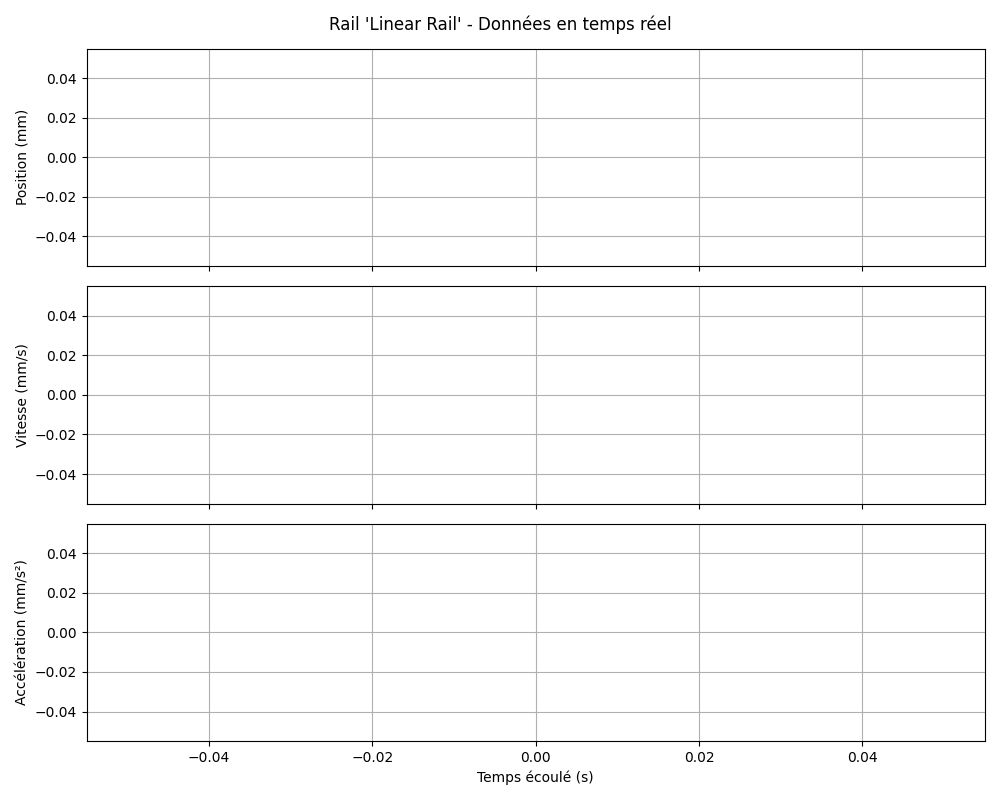

In [40]:
%matplotlib widget
%matplotlib notebook
import time
import sys
from datetime import datetime
from robodk import robolink
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Paramètres de la collecte
SAMPLE_INTERVAL = 0.1  # Intervalle entre mesures (secondes)
MAX_DURATION = 80     # Durée maximale de la collecte (secondes)

# Connexion à RoboDK
RDK = robolink.Robolink()

def collect_rail_data(rail, duration=MAX_DURATION, interval=SAMPLE_INTERVAL):
    data_log = []
    prev_val = None
    prev_time = None
    prev_speed = None
    start_time = time.time()

    # Création de la figure et des sous-graphiques
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    fig.suptitle(f"Rail '{rail.Name()}' - Données en temps réel")

    # Configuration des axes
    ax1.set_ylabel("Position (mm)")
    ax2.set_ylabel("Vitesse (mm/s)")
    ax3.set_ylabel("Accélération (mm/s²)")
    ax3.set_xlabel("Temps écoulé (s)")

    for ax in (ax1, ax2, ax3):
        ax.grid(True)

    # Initialisation des courbes
    line_pos, = ax1.plot([], [], 'b-', lw=2)
    line_speed, = ax2.plot([], [], 'g-', lw=2)
    line_acc, = ax3.plot([], [], 'r-', lw=2)

    # Données pour les courbes
    times, positions, speeds, accelerations = [], [], [], []

    def init():
        line_pos.set_data([], [])
        line_speed.set_data([], [])
        line_acc.set_data([], [])
        return line_pos, line_speed, line_acc

    def update(frame):
        nonlocal prev_val, prev_time, prev_speed

        current_time = time.time()
        elapsed = current_time - start_time

        if elapsed > duration:
            ani.event_source.stop()
            return line_pos, line_speed, line_acc

        # Lecture de la position
        joints = rail.Joints().list()
        rail_pos = joints[0]
        timestamp = datetime.now().isoformat()

        # Calculs des dérivées
        dt = current_time - prev_time if prev_time else interval
        rail_speed = (rail_pos - prev_val)/dt if prev_val is not None else 0.0
        rail_acc = (rail_speed - prev_speed)/dt if prev_speed is not None else 0.0

        # Mise à jour des données
        times.append(elapsed)
        positions.append(rail_pos)
        speeds.append(rail_speed)
        accelerations.append(rail_acc)

        # Mise à jour des courbes
        line_pos.set_data(times, positions)
        line_speed.set_data(times, speeds)
        line_acc.set_data(times, accelerations)

        # Ajustement des axes
        for ax, data in zip((ax1, ax2, ax3), (positions, speeds, accelerations)):
            ax.relim()
            ax.autoscale_view()

        # Enregistrement des valeurs
        prev_val = rail_pos
        prev_speed = rail_speed
        prev_time = current_time

        data_log.append({
            "timestamp": timestamp,
            "rail": rail.Name(),
            "rail_position": rail_pos,
            "rail_speed": rail_speed,
            "rail_acceleration": rail_acc,
            "cycle_time": elapsed
        })

        return line_pos, line_speed, line_acc

    ani = FuncAnimation(fig, update, init_func=init, interval=interval*1000, blit=False,cache_frame_data=False)
    plt.tight_layout()
    plt.show()

    return data_log

# Exemple d'utilisation pour un rail unique
if __name__ == "__main__":
    rail = RDK.Item('Linear Rail')
    if not rail.Valid():
        print("Rail invalide ! Vérifiez le nom dans RoboDK.")
        sys.exit(1)

    
    rail_data = collect_rail_data(rail)


### Collecte et visualisation en temps réel de la vitesse X de deux convoyeurs

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6552\1223132917.py:92: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, init_func=init, interval=interval*1000, blit=True)


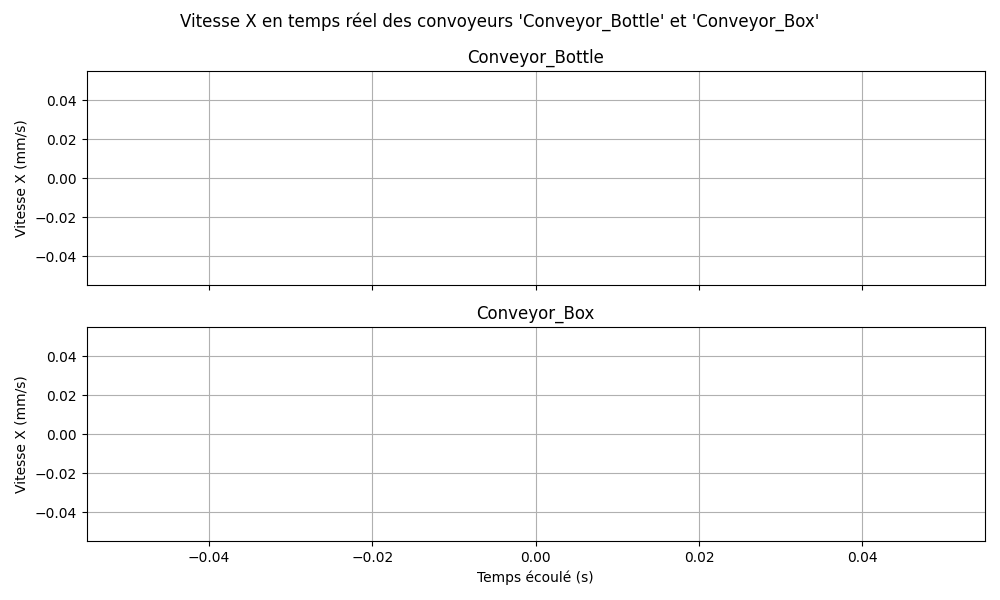

In [30]:
import time
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from robodk import robolink

RDK = robolink.Robolink()

SAMPLE_INTERVAL = 0.1  # secondes entre mesures
MAX_DURATION = 80      # durée max collecte en secondes

def collect_two_conveyors_speed_x_separate(conveyor1, conveyor2, duration=MAX_DURATION, interval=SAMPLE_INTERVAL):
    data_log = []
    start_time = time.time()

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    fig.suptitle(f"Vitesse X en temps réel des convoyeurs '{conveyor1.Name()}' et '{conveyor2.Name()}'")

    # Configuration axes convoyeur 1
    ax1.set_ylabel("Vitesse X (mm/s)")
    ax1.set_title(conveyor1.Name())
    ax1.grid(True)

    # Configuration axes convoyeur 2
    ax2.set_ylabel("Vitesse X (mm/s)")
    ax2.set_xlabel("Temps écoulé (s)")
    ax2.set_title(conveyor2.Name())
    ax2.grid(True)

    line1, = ax1.plot([], [], 'g-', lw=2)
    line2, = ax2.plot([], [], 'b-', lw=2)

    times = []
    speeds1 = []
    speeds2 = []

    prev_pos1 = None
    prev_pos2 = None
    prev_time = None

    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        return line1, line2

    def update(frame):
        nonlocal prev_pos1, prev_pos2, prev_time

        current_time = time.time()
        elapsed = current_time - start_time
        if elapsed > duration:
            ani.event_source.stop()
            return line1, line2

        # Positions X convoyeurs
        pos1 = conveyor1.Joints().list()[0]
        pos2 = conveyor2.Joints().list()[0]

        dt = current_time - prev_time if prev_time else interval

        speed1 = (pos1 - prev_pos1)/dt if prev_pos1 is not None else 0.0
        speed2 = (pos2 - prev_pos2)/dt if prev_pos2 is not None else 0.0

        prev_pos1 = pos1
        prev_pos2 = pos2
        prev_time = current_time

        times.append(elapsed)
        speeds1.append(speed1)
        speeds2.append(speed2)

        line1.set_data(times, speeds1)
        line2.set_data(times, speeds2)

        ax1.relim()
        ax1.autoscale_view()
        ax2.relim()
        ax2.autoscale_view()

        timestamp = datetime.now().isoformat()
        data_log.append({
            "timestamp": timestamp,
            conveyor1.Name() + "_position_x": pos1,
            conveyor1.Name() + "_speed_x": speed1,
            conveyor2.Name() + "_position_x": pos2,
            conveyor2.Name() + "_speed_x": speed2,
            "elapsed_time": elapsed
        })

        return line1, line2

    ani = FuncAnimation(fig, update, init_func=init, interval=interval*1000, blit=True)
    plt.tight_layout()
    plt.show()

    return data_log


if __name__ == "__main__":
    conveyor_bottle = RDK.Item('Conveyor_Bottle')
    conveyor_box = RDK.Item('Conveyor_Box')

    if not conveyor_bottle.Valid() or not conveyor_box.Valid():
        print("Un ou plusieurs convoyeurs invalides ! Vérifiez les noms dans RoboDK.")
    else:
        data = collect_two_conveyors_speed_x_separate(conveyor_bottle, conveyor_box)


### Collecte en temps réel des données du robot UR10e

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_6552\1327677010.py:126: UserWarning: frames=None which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = FuncAnimation(fig, update, init_func=init, interval=interval*1000, blit=False)


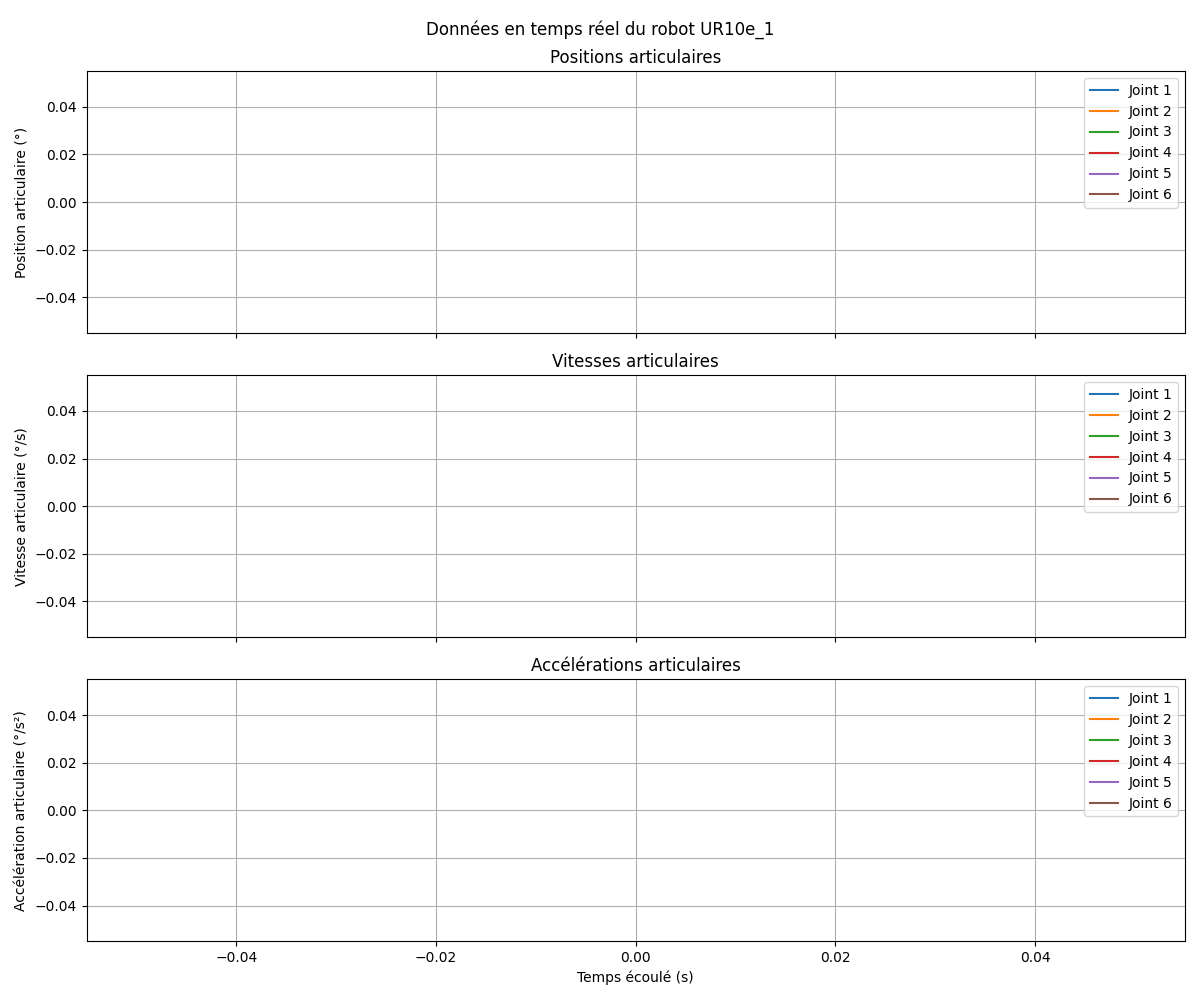

In [32]:
import time
import sys
from datetime import datetime
from robodk import robolink
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

# Paramètres de collecte
SAMPLE_INTERVAL = 0.1  # secondes
MAX_DURATION = 80      # secondes

# Connexion à RoboDK
RDK = robolink.Robolink()

def collect_ur10e_data(robot_name='UR10e_1', duration=MAX_DURATION, interval=SAMPLE_INTERVAL):
    robot = RDK.Item(robot_name)
    if not robot.Valid():
        print(f"Robot '{robot_name}' invalide ! Vérifiez le nom dans RoboDK.")
        sys.exit(1)

    data_log = []
    prev_angles = None
    prev_time = None
    prev_speed = None
    start_time = time.time()

    # Préparation de la figure
    fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f"Données en temps réel du robot {robot_name}")

    axs[0].set_ylabel("Position articulaire (°)")
    axs[0].set_title("Positions articulaires")
    axs[1].set_ylabel("Vitesse articulaire (°/s)")
    axs[1].set_title("Vitesses articulaires")
    axs[2].set_ylabel("Accélération articulaire (°/s²)")
    axs[2].set_xlabel("Temps écoulé (s)")
    axs[2].set_title("Accélérations articulaires")

    for ax in axs:
        ax.grid(True)

    # Préparer des lignes pour chaque articulation (UR10e a 6 axes)
    lines_pos = [axs[0].plot([], [], label=f'Joint {i+1}')[0] for i in range(6)]
    lines_speed = [axs[1].plot([], [], label=f'Joint {i+1}')[0] for i in range(6)]
    lines_acc = [axs[2].plot([], [], label=f'Joint {i+1}')[0] for i in range(6)]

    for ax in axs:
        ax.legend(loc='upper right')

    # Données pour tracés
    times = []
    positions = [[] for _ in range(6)]
    speeds = [[] for _ in range(6)]
    accelerations = [[] for _ in range(6)]

    def init():
        for line in lines_pos + lines_speed + lines_acc:
            line.set_data([], [])
        return lines_pos + lines_speed + lines_acc

    def update(frame):
        nonlocal prev_angles, prev_time, prev_speed

        current_time = time.time()
        elapsed = current_time - start_time
        if elapsed > duration:
            ani.event_source.stop()
            return lines_pos + lines_speed + lines_acc

        # Lire les angles articulaires (radians)
        joints = robot.Joints().list()
        # Convertir en degrés
        angles_deg = np.degrees(joints)

        timestamp = datetime.now().isoformat()

        dt = current_time - prev_time if prev_time else interval

        # Calcul vitesse et accélération articulaire
        if prev_angles is not None:
            speed = (angles_deg - prev_angles) / dt
        else:
            speed = np.zeros_like(angles_deg)

        if prev_speed is not None:
            acc = (speed - prev_speed) / dt
        else:
            acc = np.zeros_like(speed)

        times.append(elapsed)
        for i in range(6):
            positions[i].append(angles_deg[i])
            speeds[i].append(speed[i])
            accelerations[i].append(acc[i])

        # Mettre à jour les lignes
        for i in range(6):
            lines_pos[i].set_data(times, positions[i])
            lines_speed[i].set_data(times, speeds[i])
            lines_acc[i].set_data(times, accelerations[i])

        # Ajuster les axes
        for ax, data_lists in zip(axs, [positions, speeds, accelerations]):
            # Concaténer toutes les données des joints pour calculer les limites
            all_data = np.concatenate(data_lists)
            if len(all_data) > 0:
                ax.relim()
                ax.autoscale_view()

        prev_angles = angles_deg
        prev_speed = speed
        prev_time = current_time

        data_log.append({
            "timestamp": timestamp,
            "robot": robot_name,
            "positions": angles_deg.tolist(),
            "speeds": speed.tolist(),
            "accelerations": acc.tolist(),
            "elapsed_time": elapsed
        })

        return lines_pos + lines_speed + lines_acc

    ani = FuncAnimation(fig, update, init_func=init, interval=interval*1000, blit=False)
    plt.tight_layout()
    plt.show()

    return data_log

if __name__ == "__main__":
    ur10e_data = collect_ur10e_data()
